## LightGBM based Tree model

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import classification_report, precision_recall_curve, auc, confusion_matrix
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch 
import os
import torch

import warnings
warnings.filterwarnings("ignore")

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print(device)

cuda


## Base

In [3]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/train_dataset.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/test_dataset.csv"
test_data = pd.read_csv(test_data_path)

In [4]:
data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

X_test = test_data.drop(columns = "loan_status")
y_test = test_data[['loan_status']]

In [5]:
# data under 6:2:2 train,val,test set
X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data):.1%})")

Train size: 1190888 samples (80.0%)
Validation size: 297723 samples (20.0%)
Test size: 372153 samples (25.0%)


In [8]:
from lightgbm import LGBMClassifier

# 2️⃣ LightGBM 모델 정의
lgbm_model = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',  # 또는 'dart', 'goss'
    num_leaves=31,
    learning_rate=0.01,
    n_estimators=1000,
    class_weight='balanced',  # 클래스 불균형 처리 시 사용
    random_state=42,
    verbose=1
)

[LightGBM] [Info] Number of positive: 232308, number of negative: 958580
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3081
[LightGBM] [Info] Number of data points in the train set: 1190888, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


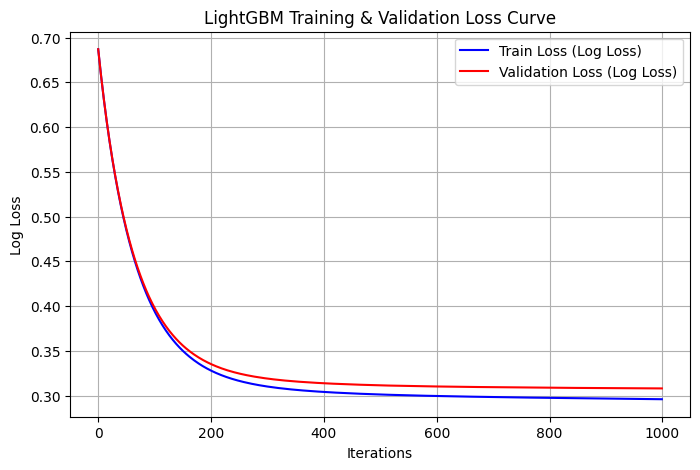

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.86      0.92    299557
           1       0.62      0.91      0.73     72596

    accuracy                           0.87    372153
   macro avg       0.79      0.88      0.82    372153
weighted avg       0.90      0.87      0.88    372153



In [12]:
# 3️⃣ 모델 학습
lgbm_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='logloss'
)

# 4️⃣ Train & Validation Loss 추출 및 시각화
evals_result = lgbm_model.evals_result_
train_loss = evals_result['training']['binary_logloss']
val_loss = evals_result['valid_1']['binary_logloss']

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('LightGBM Training & Validation Loss Curve')
plt.legend()
plt.grid()
plt.show()

# 5️⃣ 예측 및 평가
y_prob = lgbm_model.predict_proba(X_test)[:, 1]
threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 7️⃣ ROC Curve & AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 8️⃣ Precision-Recall Curve & AU-PRC
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

In [13]:
# 6️⃣ Confusion Matrix 구성 요소 (TP, TN, FP, FN)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(f"✅ Confusion Matrix:")
print(cm)
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

✅ Confusion Matrix:
[[258441  41116]
 [  6856  65740]]
True Positives (TP): 65740
True Negatives (TN): 258441
False Positives (FP): 41116
False Negatives (FN): 6856


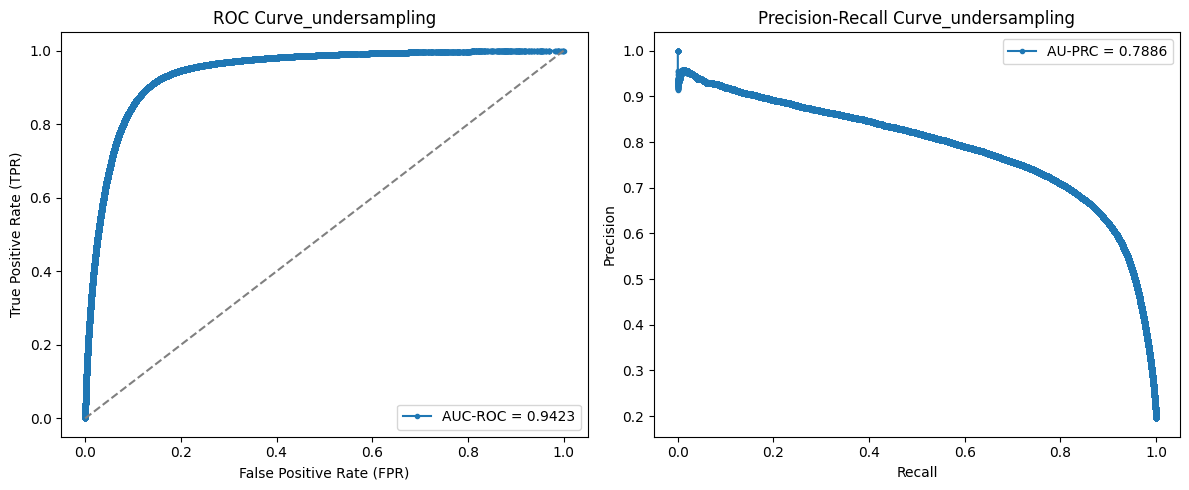

In [14]:
# 8️⃣ ROC & Precision-Recall Curve 시각화 함수
def plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc):
    plt.figure(figsize=(12, 5))

    # 🔹 ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, marker='.', label=f"AUC-ROC = {auc_roc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # 랜덤 모델 기준선
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve_undersampling')
    plt.legend()

    # 🔹 Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, marker='.', label=f"AU-PRC = {auc_prc:.4f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve_undersampling')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 9️⃣ 결과 시각화 실행
plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc)

## Undersampling

In [15]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/train_dataset.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/test_dataset.csv"
test_data = pd.read_csv(test_data_path)

In [16]:
data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

X_test = test_data.drop(columns = "loan_status")
y_test = test_data[['loan_status']]

In [17]:
# data under 6:2:2 train,val,test set
X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.13, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data):.1%})")

Train size: 1295091 samples (87.0%)
Validation size: 193520 samples (13.0%)
Test size: 372153 samples (25.0%)


In [18]:
# 클래스별 샘플 개수 확인
print("Original class distribution:\n", y_train.value_counts())

# 언더샘플링 적용 (Random Undersampling)
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X_train, y_train)

# 결과 확인 (각 데이터셋 크기)
print(f"Original data size: {data_x.shape[0]} samples")
print(f"Undersampled data size: {X_under.shape[0]} samples")

# 데이터프레임 변환 (필요하면)
data_under = pd.concat([pd.DataFrame(X_under, columns=data_x.columns), pd.DataFrame(y_under, columns=['loan_status'])], axis=1)

# 언더샘플링 및 오버샘플링 결과 확인
print(f"\nUndersampling imbalance check\n{data_under['loan_status'].value_counts()}")

Original class distribution:
 loan_status
0              1042456
1               252635
Name: count, dtype: int64
Original data size: 1488611 samples
Undersampled data size: 505270 samples

Undersampling imbalance check
loan_status
0    252635
1    252635
Name: count, dtype: int64


In [19]:
X_train = data_under.drop(columns=['loan_status'])  # Feature (입력 데이터)
y_train = data_under[['loan_status']]  # Target (타겟 변수)

In [20]:
from lightgbm import LGBMClassifier

# 2️⃣ LightGBM 모델 정의
lgbm_model = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',  # 또는 'dart', 'goss'
    num_leaves=31,
    learning_rate=0.01,
    n_estimators=1000,
    class_weight='balanced',  # 클래스 불균형 처리 시 사용
    random_state=42,
    verbose=1
)

[LightGBM] [Info] Number of positive: 252635, number of negative: 252635
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3079
[LightGBM] [Info] Number of data points in the train set: 505270, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


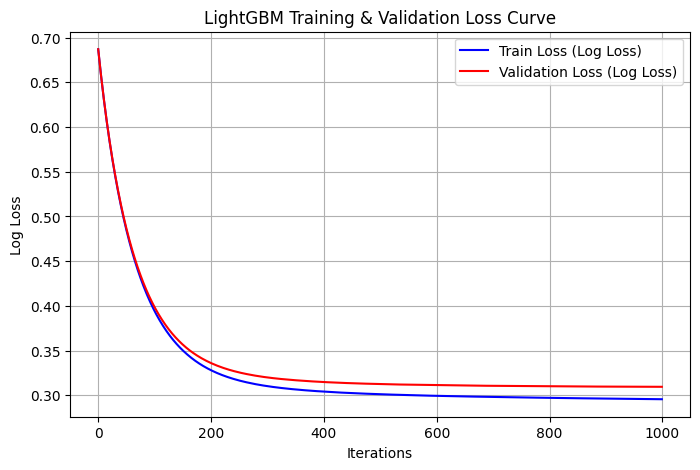

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.86      0.91    299557
           1       0.61      0.91      0.73     72596

    accuracy                           0.87    372153
   macro avg       0.79      0.88      0.82    372153
weighted avg       0.90      0.87      0.88    372153



In [21]:
# 3️⃣ 모델 학습
lgbm_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='logloss'
)

# 4️⃣ Train & Validation Loss 추출 및 시각화
evals_result = lgbm_model.evals_result_
train_loss = evals_result['training']['binary_logloss']
val_loss = evals_result['valid_1']['binary_logloss']

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('LightGBM Training & Validation Loss Curve')
plt.legend()
plt.grid()
plt.show()

# 5️⃣ 예측 및 평가
y_prob = lgbm_model.predict_proba(X_test)[:, 1]
threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 7️⃣ ROC Curve & AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 8️⃣ Precision-Recall Curve & AU-PRC
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

In [22]:
# 6️⃣ Confusion Matrix 구성 요소 (TP, TN, FP, FN)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(f"✅ Confusion Matrix:")
print(cm)
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

✅ Confusion Matrix:
[[258280  41277]
 [  6794  65802]]
True Positives (TP): 65802
True Negatives (TN): 258280
False Positives (FP): 41277
False Negatives (FN): 6794


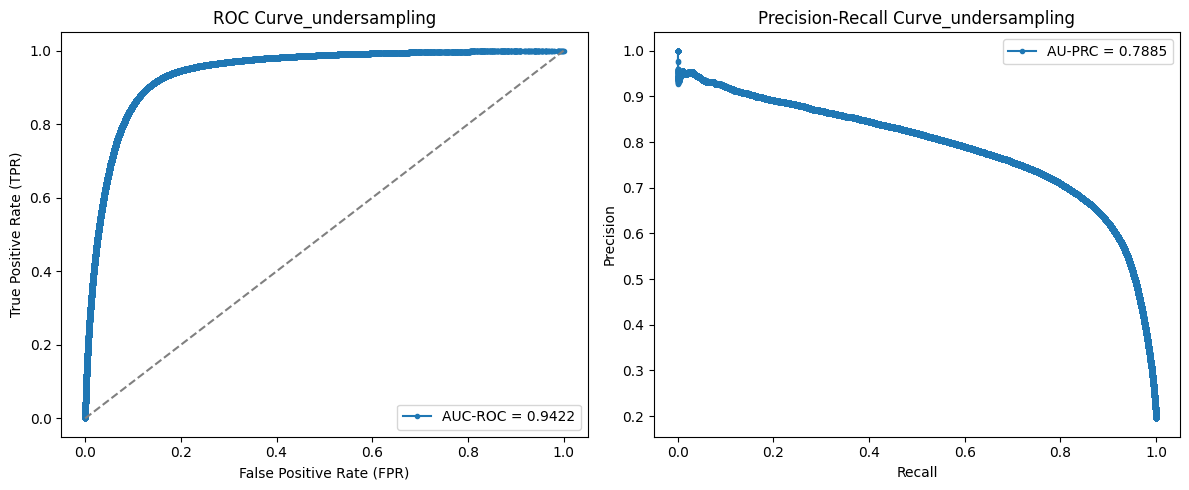

In [23]:
# 8️⃣ ROC & Precision-Recall Curve 시각화 함수
def plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc):
    plt.figure(figsize=(12, 5))

    # 🔹 ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, marker='.', label=f"AUC-ROC = {auc_roc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # 랜덤 모델 기준선
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve_undersampling')
    plt.legend()

    # 🔹 Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, marker='.', label=f"AU-PRC = {auc_prc:.4f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve_undersampling')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 9️⃣ 결과 시각화 실행
plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc)

## Oversampling

In [24]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/train_dataset.csv"
data = pd.read_csv(data_path, low_memory=False)

In [25]:
data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

In [26]:
# data under 6:2:2 train,val,test set
X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.33, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data):.1%})")

Train size: 997369 samples (67.0%)
Validation size: 491242 samples (33.0%)
Test size: 372153 samples (25.0%)


In [27]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# SMOTE 객체 생성
smote = SMOTE(random_state=42)

# 오버샘플링 수행
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 결과 확인
print(f"✅ SMOTE 적용 완료")
print(f"📦 X_train_smote shape: {X_train_smote.shape}")
print(y_train_smote.value_counts())

## 증강 시간이 오래 걸리기 때문 데이터 저장을 한다.
augmentation_data = pd.concat([X_train_smote, y_train_smote], axis = 1)

✅ SMOTE 적용 완료
📦 X_train_smote shape: (1605622, 15)
loan_status
0              802811
1              802811
Name: count, dtype: int64


In [28]:
X_train = augmentation_data.drop(columns='loan_status')
y_train = augmentation_data[['loan_status']]

In [29]:
from lightgbm import LGBMClassifier

# 2️⃣ LightGBM 모델 정의
lgbm_model = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',  # 또는 'dart', 'goss'
    num_leaves=31,
    learning_rate=0.01,
    n_estimators=1000,
    class_weight='balanced',  # 클래스 불균형 처리 시 사용
    random_state=42,
    verbose=1
)

[LightGBM] [Info] Number of positive: 802811, number of negative: 802811
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3629
[LightGBM] [Info] Number of data points in the train set: 1605622, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


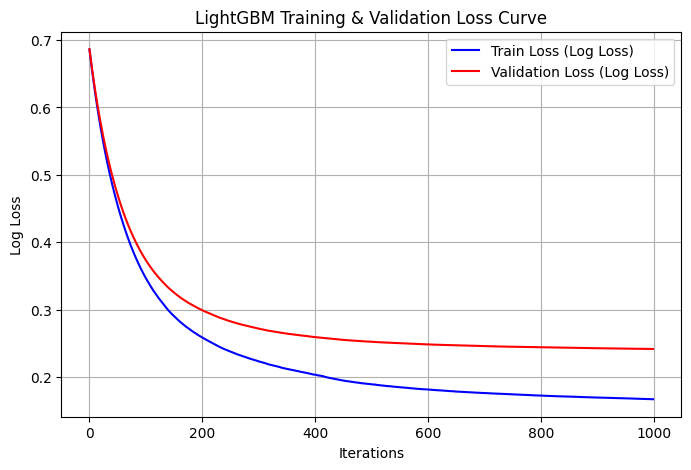

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94    299557
           1       0.71      0.79      0.75     72596

    accuracy                           0.90    372153
   macro avg       0.83      0.85      0.84    372153
weighted avg       0.90      0.90      0.90    372153



In [30]:
# 3️⃣ 모델 학습
lgbm_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='logloss'
)

# 4️⃣ Train & Validation Loss 추출 및 시각화
evals_result = lgbm_model.evals_result_
train_loss = evals_result['training']['binary_logloss']
val_loss = evals_result['valid_1']['binary_logloss']

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('LightGBM Training & Validation Loss Curve')
plt.legend()
plt.grid()
plt.show()

# 5️⃣ 예측 및 평가
y_prob = lgbm_model.predict_proba(X_test)[:, 1]
threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 7️⃣ ROC Curve & AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 8️⃣ Precision-Recall Curve & AU-PRC
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

In [31]:
# 6️⃣ Confusion Matrix 구성 요소 (TP, TN, FP, FN)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(f"✅ Confusion Matrix:")
print(cm)
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

✅ Confusion Matrix:
[[276716  22841]
 [ 15595  57001]]
True Positives (TP): 57001
True Negatives (TN): 276716
False Positives (FP): 22841
False Negatives (FN): 15595


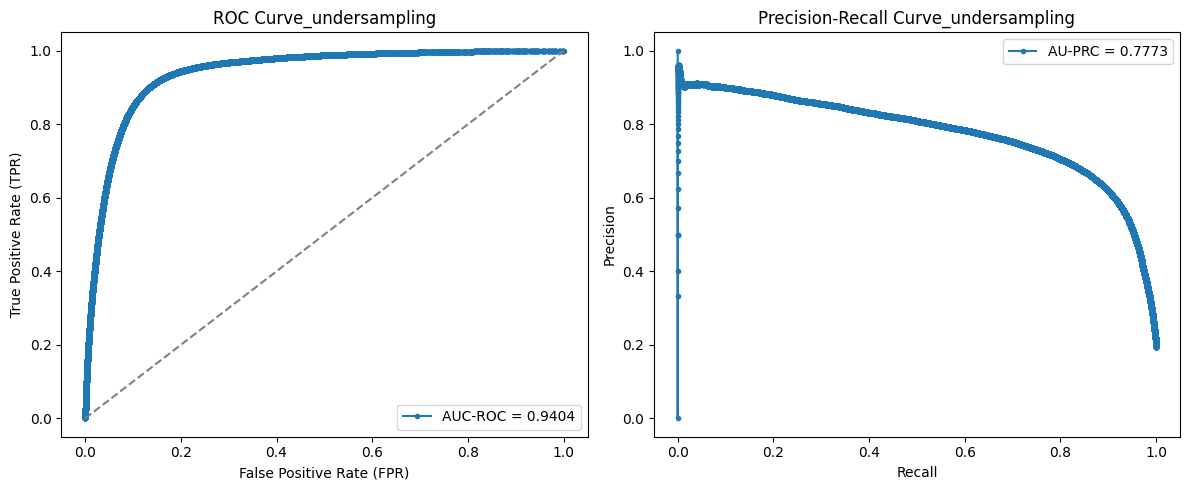

In [32]:
# 8️⃣ ROC & Precision-Recall Curve 시각화 함수
def plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc):
    plt.figure(figsize=(12, 5))

    # 🔹 ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, marker='.', label=f"AUC-ROC = {auc_roc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # 랜덤 모델 기준선
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve_undersampling')
    plt.legend()

    # 🔹 Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, marker='.', label=f"AU-PRC = {auc_prc:.4f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve_undersampling')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 9️⃣ 결과 시각화 실행
plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc)

## TableGan

In [33]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/train_dataset.csv"
data = pd.read_csv(data_path, low_memory=False)

In [34]:
data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

In [35]:
# data under 6:2:2 train,val,test set
X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.33, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data):.1%})")

Train size: 997369 samples (67.0%)
Validation size: 491242 samples (33.0%)
Test size: 372153 samples (25.0%)


In [36]:
train_dataset = pd.concat([X_train, y_train], axis=1)

fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/samples/train/train_OI_11_00_fake.csv"
fake = pd.read_csv(fake_path)
fake['loan_status'] = 1

In [37]:
from sklearn.utils import shuffle

train_total = pd.concat([train_dataset,fake])
train_total = shuffle(train_total, random_state=42)

In [38]:
X_train = train_total.drop(columns='loan_status')
y_train = train_total[['loan_status']]

In [39]:
from lightgbm import LGBMClassifier

# 2️⃣ LightGBM 모델 정의
lgbm_model = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',  # 또는 'dart', 'goss'
    num_leaves=31,
    learning_rate=0.01,
    n_estimators=1000,
    class_weight='balanced',  # 클래스 불균형 처리 시 사용
    random_state=42,
    verbose=1
)

[LightGBM] [Info] Number of positive: 1094558, number of negative: 802811
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3082
[LightGBM] [Info] Number of data points in the train set: 1897369, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


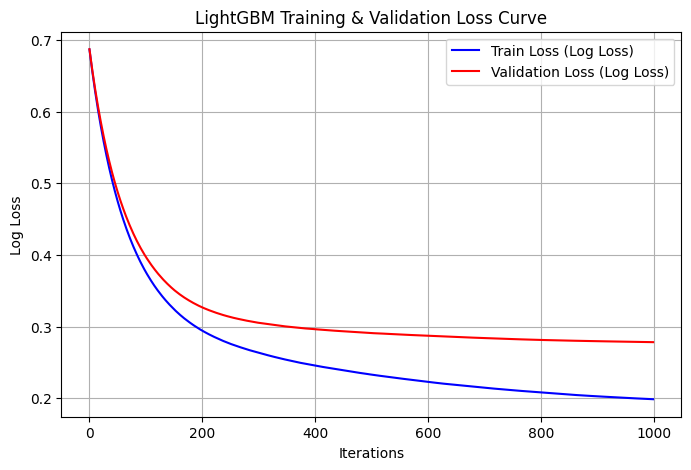

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93    299557
           1       0.67      0.77      0.72     72596

    accuracy                           0.88    372153
   macro avg       0.81      0.84      0.82    372153
weighted avg       0.89      0.88      0.88    372153



In [40]:
# 3️⃣ 모델 학습
lgbm_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='logloss'
)

# 4️⃣ Train & Validation Loss 추출 및 시각화
evals_result = lgbm_model.evals_result_
train_loss = evals_result['training']['binary_logloss']
val_loss = evals_result['valid_1']['binary_logloss']

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('LightGBM Training & Validation Loss Curve')
plt.legend()
plt.grid()
plt.show()

# 5️⃣ 예측 및 평가
y_prob = lgbm_model.predict_proba(X_test)[:, 1]
threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 7️⃣ ROC Curve & AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 8️⃣ Precision-Recall Curve & AU-PRC
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

In [41]:
# 6️⃣ Confusion Matrix 구성 요소 (TP, TN, FP, FN)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(f"✅ Confusion Matrix:")
print(cm)
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

✅ Confusion Matrix:
[[272325  27232]
 [ 16832  55764]]
True Positives (TP): 55764
True Negatives (TN): 272325
False Positives (FP): 27232
False Negatives (FN): 16832


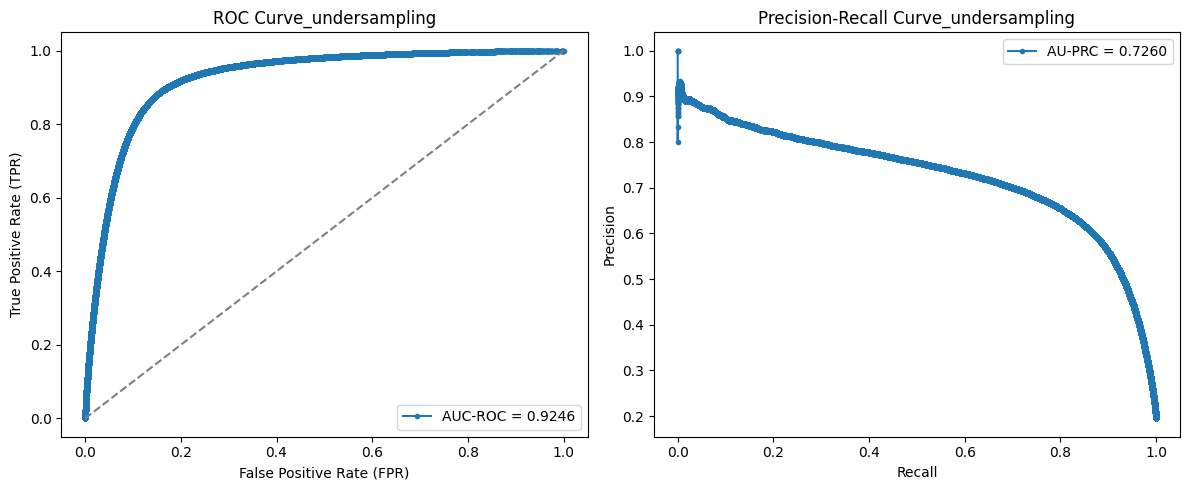

In [42]:
# 8️⃣ ROC & Precision-Recall Curve 시각화 함수
def plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc):
    plt.figure(figsize=(12, 5))

    # 🔹 ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, marker='.', label=f"AUC-ROC = {auc_roc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # 랜덤 모델 기준선
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve_undersampling')
    plt.legend()

    # 🔹 Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, marker='.', label=f"AU-PRC = {auc_prc:.4f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve_undersampling')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 9️⃣ 결과 시각화 실행
plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc)